# Comparison of cost function section calculators

The 1D section of the cost function has a general form $b_0 \sin 2\theta + b_1 \cos 2\theta + b_2 \sin \theta + b_3 \cos \theta + b_4$. In principle, knowing the value of the function at 5 distinct points allows us to find the values of the $b_i$ coefficients, and thereby the minimum of the function. However, when the observed values of the function have statistical and other uncertainties, performing a maximum likelihood fit using data from a larger number of points may result in a more accurate estimation of the coefficients.

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

sys.path.append('..')
from cost_sections import *

## Experiment

Draw parameters $b_i$ of $f(\theta) = b_0 \sin 2\theta + b_1 \cos 2\theta + b_2 \sin \theta + b_3 \cos \theta + b_4$ randomly and normalize them so that $0 < f(\theta) < 1$. Measurement of the cost value at a given value of $\theta$ is simulated by drawing from a binomial distribution $B(n_{\text{shots}}, f(\theta))$. In each trial, the cost section function and a "current position" are randomly defined and passed to the two cost section calculation algorithms (matrix inversion and fit). The two algorithms use identical total number of shots (the fit algorithm therefore uses fewer shots per point than the inversion algorithm). Statistical errors of the two methods are compared in the end.

In [2]:
rng = np.random.default_rng()

def fun(th, b):
    return b[0] * np.sin(2. * th) + b[1] * np.cos(2. * th) + b[2] * np.sin(th) + b[3] * np.cos(th) + b[4]

def grad(th, b):
    return 2. * b[0] * np.cos(2. * th) - 2. * b[1] * np.sin(2. * th) + b[2] * np.cos(th) - b[3] * np.sin(th)

def hess(th, b):
    return -4. * b[0] * np.sin(2. * th) - 4. * b[1] * np.cos(2. * th) - b[2] * np.sin(th) - b[3] * np.cos(th)

def normalize_fun(b):
    if grad(0., b) < 0.:
        x0 = 0.
        shift = 0.01
    else:
        x0 = 2. * np.pi
        shift = -0.01

    fun_array_input = lambda x: fun(x[0], b)
    positive_grad = lambda x: grad(x, b)
    positive_hess = lambda x: hess(x, b)

    # first minimum
    res_min1 = sciopt.minimize(fun_array_input, [x0], method='trust-ncg', jac=positive_grad, hess=positive_hess, options={'initial_trust_radius': np.pi / 8.})

    negative_fun_array_input = lambda x: -fun(x[0], b)
    negative_grad = lambda x: -grad(x, b)
    negative_hess = lambda x: -hess(x, b)

    # first maximum
    res_max1 = sciopt.minimize(negative_fun_array_input, [res_min1.x + shift], method='trust-ncg', jac=negative_grad, hess=negative_hess, options={'initial_trust_radius': np.pi / 8.})

    # second minimum
    res_min2 = sciopt.minimize(fun_array_input, [res_max1.x + shift], method='trust-ncg', jac=positive_grad, hess=positive_hess, options={'initial_trust_radius': np.pi / 8.})
    
    if (shift > 0. and res_min2.x < 2. * np.pi) or (shift < 0. and res_min2.x > 0.):
        # second maximum
        res_max2 = sciopt.minimize(negative_fun_array_input, [res_min2.x + shift], method='trust-ncg', jac=negative_grad, hess=negative_hess, options={'initial_trust_radius': np.pi / 8.})
        
        minimum = min(res_min1.fun, res_min2.fun)
        maximum = max(-res_max1.fun, -res_max2.fun)
    else:
        minimum = res_min1.fun
        maximum = -res_max1.fun
        
    if minimum < 0.:
        b[4] += -minimum
        maximum += -minimum
    if maximum > 1.:
        b /= maximum
        
    return b

def get_costs(th, b, shots):
    costs_truth = fun(th, b)
    costs = rng.binomial([shots] * th.shape[0], costs_truth) / shots
    return costs

def compare_stat_errors(shots, num_exp=200):
    matrix_errors = np.empty(num_exp, dtype='f8')
    fit_errors = np.empty(num_exp, dtype='f8')
    
    points_to_parameters = 4
    
    matrix = InversionGeneral()
    fit = FitGeneral(points_to_parameters)
    exact = CostSectionGeneral()

    for iexp in range(num_exp):
        current = rng.random() * 2. * np.pi
        matrix.set_thetas(current)
        fit.set_thetas(current)
        exact.current = current

        b = rng.random(5)
        b = normalize_fun(b)

        matrix.set_coeffs(get_costs(matrix.thetas, b, points_to_parameters * shots))
        opt_matrix = matrix.minimum()

        fit.set_coeffs(get_costs(fit.thetas, b, shots))
        opt_fit = fit.minimum()

        exact.coeffs = b
        opt_exact = exact.minimum()

        matrix_errors[iexp] = opt_matrix - opt_exact
        fit_errors[iexp] = opt_fit - opt_exact
        
    return matrix_errors, fit_errors

In [3]:
matrix_errors, fit_errors = compare_stat_errors(4096)

/usr/local/lib/python3.8/dist-packages/scipy/optimize/optimize.py:1058: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/usr/local/lib/python3.8/dist-packages/scipy/optimize/optimize.py:1058: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


matrix outliers 3
fit outliers 0


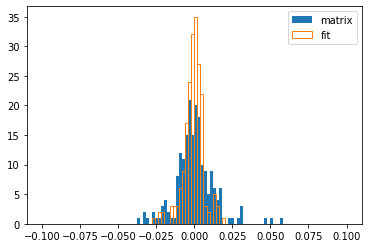

In [4]:
print('matrix outliers', np.asarray(np.abs(matrix_errors) > 0.1).nonzero()[0].shape[0])
print('fit outliers', np.asarray(np.abs(fit_errors) > 0.1).nonzero()[0].shape[0])

plt.hist(matrix_errors, 100, range=(-0.1, 0.1), label='matrix')
plt.hist(fit_errors, 100, range=(-0.1, 0.1), label='fit', fill=False, edgecolor='#ff7f0e')
plt.legend()

In [5]:
matrix_errors, fit_errors = compare_stat_errors(2048)

/usr/local/lib/python3.8/dist-packages/scipy/optimize/optimize.py:1058: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/usr/local/lib/python3.8/dist-packages/scipy/optimize/optimize.py:1058: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/usr/local/lib/python3.8/dist-packages/scipy/optimize/optimize.py:1058: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


matrix outliers 3
fit outliers 1


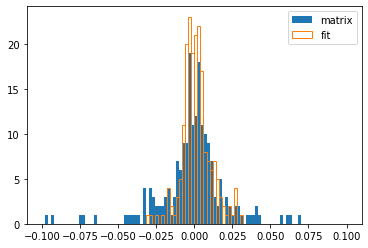

In [6]:
print('matrix outliers', np.asarray(np.abs(matrix_errors) > 0.1).nonzero()[0].shape[0])
print('fit outliers', np.asarray(np.abs(fit_errors) > 0.1).nonzero()[0].shape[0])

plt.hist(matrix_errors, 100, range=(-0.1, 0.1), label='matrix')
plt.hist(fit_errors, 100, range=(-0.1, 0.1), label='fit', fill=False, edgecolor='#ff7f0e')
plt.legend()

In [7]:
matrix_errors, fit_errors = compare_stat_errors(8192)

/usr/local/lib/python3.8/dist-packages/scipy/optimize/optimize.py:1058: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


matrix outliers 3
fit outliers 0


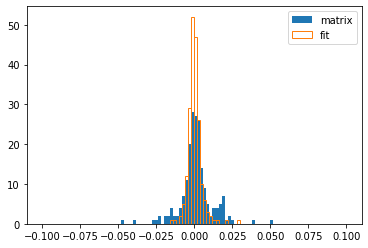

In [8]:
print('matrix outliers', np.asarray(np.abs(matrix_errors) > 0.1).nonzero()[0].shape[0])
print('fit outliers', np.asarray(np.abs(fit_errors) > 0.1).nonzero()[0].shape[0])

plt.hist(matrix_errors, 100, range=(-0.1, 0.1), label='matrix')
plt.hist(fit_errors, 100, range=(-0.1, 0.1), label='fit', fill=False, edgecolor='#ff7f0e')
plt.legend()

## Conclusion

Fit method seems to be slightly more robust against statistical fluctuations of the measurement results.